In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
toCompute=True

In [3]:
classifier_name="tree"
max_depth=3

# Import dataset

In [4]:
dataset_name="compas"
results_output="results/results_tree/figures"

In [5]:
outputDirResults=f"./{results_output}/{dataset_name}/{classifier_name}/"
saveResults=True

if saveResults:
    from src.utils import saveJson
    from pathlib import Path
    Path(outputDirResults).mkdir(parents=True, exist_ok=True)

In [6]:
from src.import_datasets import import_process_compas
risk_class_type=False
dfI =import_process_compas(discretize=False, risk_class=risk_class_type)
dfI.reset_index(drop=True, inplace=True)
dfI["class"].replace({0:"Not recidivate", 1:"Recidivate"}, inplace=True)
df=dfI.copy()
df.head()

,age_cat,c_charge_degree,race,sex,class,priors_count,length_of_stay
0,Greater than 45,F,Other,Male,Not recidivate,0,1.0
1,25 - 45,F,African-American,Male,Recidivate,0,10.0
2,Less than 25,F,African-American,Male,Recidivate,4,1.0
3,25 - 45,M,Other,Male,Not recidivate,0,1.0
4,25 - 45,F,Caucasian,Male,Recidivate,14,6.0


In [7]:
from sklearn import model_selection
import numpy as np

np.random.seed(42)
df_train, df_test = model_selection.train_test_split(df, train_size=0.7)

# Process data

In [8]:
from ProcessedDataset_v2 import ProcessedDatasetTrainTest

In [9]:
pc = ProcessedDatasetTrainTest(df_train, df_test)

from sklearn.tree import DecisionTreeClassifier
clf_init = DecisionTreeClassifier(random_state=7, max_depth=max_depth)
pc.processTrainTestDataset(clf_init, dataset_name=dataset_name)

In [10]:
predicted=np.argmax(pc.predict_fn(pc.test.values), axis=1)
FP=[i for i,p in enumerate(predicted) if p==1 and pc.labels_test[i]==0]
FN=[i for i,p in enumerate(predicted) if p==0 and pc.labels_test[i]==1]
mispredicted=[i for i,p in enumerate(predicted) if p!=pc.labels_test[i]]
correct_prediction=[i for i,p in enumerate(predicted) if p==pc.labels_test[i]]

In [11]:
from sklearn.metrics import accuracy_score
print("Accuracy: ", round(accuracy_score(pc.labels_test, predicted),4))

Accuracy:  0.6631


In [12]:
from sklearn import tree

text_representation = tree.export_text(pc.clf)
print(text_representation)

|--- feature_13 <= 0.08
|   |--- feature_2 <= 0.50
|   |   |--- feature_13 <= 0.02
|   |   |   |--- class: 0
|   |   |--- feature_13 >  0.02
|   |   |   |--- class: 0
|   |--- feature_2 >  0.50
|   |   |--- feature_12 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_12 >  0.50
|   |   |   |--- class: 1
|--- feature_13 >  0.08
|   |--- feature_13 <= 0.26
|   |   |--- feature_1 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_1 >  0.50
|   |   |   |--- class: 0
|   |--- feature_13 >  0.26
|   |   |--- feature_13 <= 0.47
|   |   |   |--- class: 1
|   |   |--- feature_13 >  0.47
|   |   |   |--- class: 1



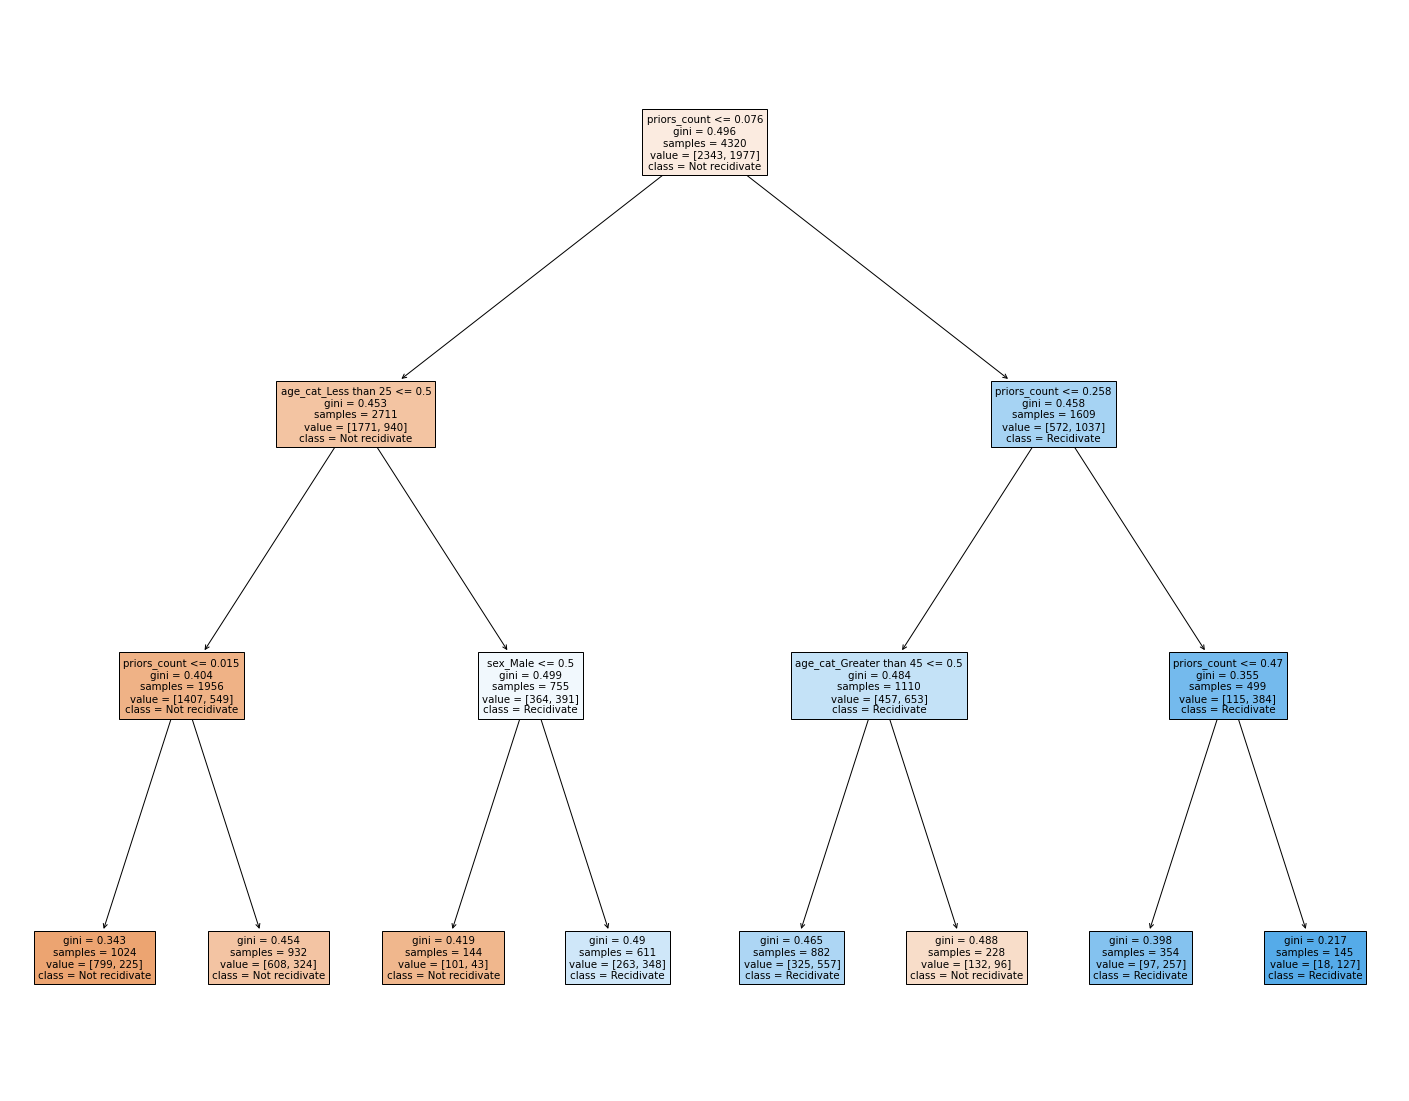

In [13]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(pc.clf, 
                   feature_names=pc.OH_X_test_cols.columns,
                   class_names=pc.d_train.class_values(),
                   filled=True)

In [14]:
def decodeValue(instance, column_name, value, pc, threshold_v=False):
    fr=frozenset([f"{column_name}=value"])
    fr_col=frozenset([column_name])
    if column_name in pc.min_max_scaler_cols:
            index=pc.min_max_scaler_cols.index(column_name)
            convert = np.zeros((1, len(pc.min_max_scaler_cols)))
            convert[0,index]=value
            threshold_value=pc.min_max_scaler.inverse_transform(convert)[0,index]
            fr=frozenset([f"{column_name}={threshold_value.round(2)}"])
            return threshold_value.round(2), fr, (fr, fr_col)
    if column_name in pc.getMappingOHColumnsTupleAttrValue():
            attr,attrv=pc.getMappingOHColumnsTupleAttrValue()[column_name]
            if threshold_v==False:
                conv_v=False if value<0.5 else True
                rel="!=" if value<0.5 else "="
                attr_values=dict(pc.getLabelEncodedNames())[attr]
                if len(attr_values)==2:
                    index=attr_values.index(attrv)
                    index=(index+1)%2
                    rel, attrv="=", attr_values[index]
                df_sel=instance[[col for col in instance if col.startswith(attr)]].astype(bool)
                attrv_equal=pc.getMappingOHColumnsTupleAttrValue()[df_sel.columns[df_sel.values[0]].values[0]][1]
                fr=frozenset([f"{attr}{rel}{attrv}"])
                fr_instance=(frozenset([f"{attr}={attrv_equal}"]), frozenset([attr]))
                return conv_v, fr, fr_instance
    return value, fr, (fr, fr_col)

In [15]:
def decodeContinuousValue(instance, column_name, value, pc, threshold_v=False):
    fr=frozenset([f"{column_name}=value"])
    fr_col=frozenset([column_name])
    if column_name in pc.min_max_scaler_cols:
            index=pc.min_max_scaler_cols.index(column_name)
            convert = np.zeros((1, len(pc.min_max_scaler_cols)))
            convert[0,index]=value
            decoded_value=pc.min_max_scaler.inverse_transform(convert)[0,index]
            return decoded_value.round(2)    

In [16]:
def getPathDecisionTree(clf, instance, pc, verbose=False):
    path_fr=frozenset([])
    path_fr_instance=frozenset([])
    path_fr_attr=frozenset([])
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    
    
    X_test=instance.values
    node_indicator = clf.decision_path(X_test)
    leaf_id = clf.apply(X_test)

    sample_id = 0
    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                        node_indicator.indptr[sample_id + 1]]


    
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue
        
        # check if value of the split feature for sample 0 is below threshold
        if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"
        
        
        threshold_value, _, _=decodeValue(instance, instance.columns[feature[node_id]], threshold[node_id], pc, threshold_v=True)
        column_value, fr, fr_instance_att=decodeValue(instance, instance.columns[feature[node_id]], X_test[sample_id, feature[node_id]], pc)
        path_fr=path_fr.union(fr)
        path_fr_instance=path_fr_instance.union(fr_instance_att[0])
        path_fr_attr=path_fr_attr.union(fr_instance_att[1])
        if verbose:
            print("decision node {node} : (X_test[{sample}, {feature}] = {value}) "
                  "{inequality} {threshold})".format(
                      node=node_id,
                      sample=sample_id,
                      feature=feature[node_id],
                      value=X_test[sample_id, feature[node_id]],
                      inequality=threshold_sign,
                      threshold=threshold[node_id]))

            print("decision node {node} : ({column_name} = {value}) "
                  "{inequality} {threshold})".format(
                      node=node_id,
                      column_name=instance.columns[feature[node_id]],
                      value=column_value,
                      inequality=threshold_sign,
                      threshold=threshold_value))
    return path_fr, path_fr_instance, path_fr_attr
        

## Example

In [17]:
sample_id=7 #1

display(pc.d_explain._decoded_df.iloc[sample_id:sample_id+1])
print(pc.d_explain._decoded_df.iloc[sample_id:sample_id+1].values)
instance=pc.OH_X_test_cols.iloc[sample_id:sample_id+1]
#display(instance)


clf=pc.clf
path_fr, path_fr_instance,path_fr_attr=getPathDecisionTree(clf, instance, pc, verbose=True)

print(path_fr)
print()
print(path_fr_instance)
print()
print(path_fr_attr)

,age_cat,c_charge_degree,race,sex,priors_count,length_of_stay,class
7,25 - 45,F,Other,Male,8,1,Recidivate


[['25 - 45' 'F' 'Other' 'Male' 8 1.0 'Recidivate']]
decision node 0 : (X_test[0, 13] = 0.24242424242424243) > 0.07575757801532745)
decision node 0 : (priors_count = 8.0) > 2.5)
decision node 8 : (X_test[0, 13] = 0.24242424242424243) <= 0.25757576525211334)
decision node 8 : (priors_count = 8.0) <= 8.5)
decision node 9 : (X_test[0, 1] = 0.0) <= 0.5)
decision node 9 : (age_cat_Greater than 45 = False) <= 0.5)
frozenset({'priors_count=8.0', 'age_cat!=Greater than 45'})

frozenset({'priors_count=8.0', 'age_cat=25 - 45'})

frozenset({'age_cat', 'priors_count'})


In [18]:
a=pc.d_explain._decoded_df
a.loc[(a["age_cat"]=="Greater than 45") & (a["priors_count"]>2.5)].head(20)

,age_cat,c_charge_degree,race,sex,priors_count,length_of_stay,class
17,Greater than 45,M,African-American,Male,8,1,Recidivate
24,Greater than 45,M,African-American,Male,22,1,Not recidivate
44,Greater than 45,F,Caucasian,Male,3,1,Recidivate
89,Greater than 45,F,African-American,Male,5,243,Recidivate
118,Greater than 45,M,African-American,Male,9,39,Recidivate
132,Greater than 45,M,African-American,Male,14,31,Not recidivate
153,Greater than 45,M,Caucasian,Male,13,66,Recidivate
162,Greater than 45,F,Caucasian,Female,5,1,Not recidivate
185,Greater than 45,M,African-American,Male,23,1,Recidivate
189,Greater than 45,F,African-American,Male,16,1,Not recidivate


# Explainers

## LIME

In [19]:
import lime
import lime.lime_tabular
import numpy as np
np.random.seed(42)

In [20]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(pc.train.values ,feature_names = pc.feature_names,class_names=pc.class_names,
                                                   categorical_features=pc.categorical_features_pos, 
                                                   categorical_names=pc.categorical_names_LE, random_state=42)

## SHAP

In [21]:
if toCompute:
    import shap
    if classifier_name in ["RF", "tree"]:
        shap_explainer = shap.TreeExplainer(pc.clf)
    else:
        shap_explainer = shap.KernelExplainer(model=pc.predict_fn_OH, data=pc.OH_X_train.values)#, link="logit")

## Anchor

In [22]:
from anchor import utils
from anchor import anchor_tabular

In [23]:
anchor_explainer = anchor_tabular.AnchorTabularExplainer(
    pc.class_names,
    pc.feature_names,
    pc.train.values,
    pc.categorical_names_LE)

## LACE

In [24]:
from src.LACE_explainer import LACE_explainer

lace_explainer = LACE_explainer(pc.d_train,pc.predict_fn, dataset_name="COMPAS")

# Comparison

In [25]:
outdir_lace=f"./results/{dataset_name}/lace"
outdir_lime=f"./results/{dataset_name}/lime"
outdir_shap=f"./results/{dataset_name}/shap"

saveFig=False

if saveFig:
    from pathlib import Path
    Path(outdir_lace).mkdir(parents=True, exist_ok=True)
    Path(outdir_lime).mkdir(parents=True, exist_ok=True)
    Path(outdir_shap).mkdir(parents=True, exist_ok=True)

In [26]:
def lime_explanation_attr_sorted(exp_lime, label):
    exp = dict(exp_lime.as_list(label=label))
    names = exp_lime.domain_mapper.feature_names
    exp_lime_dict = {}
    for n in names:
        if n in exp:
            exp_lime_dict[n]=exp[n]
        else:
            for k in exp.keys():
                if n in k:
                    exp_lime_dict[n]=exp[k]
    return exp_lime_dict


def checkRankingTarget(rankings, target):
    targets_hit=[1 for t in target if rankings[t]<=len(target)]
    return sum(targets_hit)/len(target)

def getFeatureRankingList(k_v, feature_names, absValue=False):
    rankings=k_v.copy()
    if absValue:
        for rank, k in enumerate(sorted(k_v, key=lambda k: abs(k_v[k]), reverse=True), 1):
            rankings[k]=rank
    else:
        for rank, k in enumerate(sorted(k_v, key=k_v.get, reverse=True), 1):
            rankings[k]=rank
    rankings={feature_names[f]:list(rankings.values())[f] for f in range(len(feature_names))}
    return rankings

def evaluateRankingTarget(k_v,feature_names, target, absValue=False):
    rankings=getFeatureRankingList(k_v, feature_names, absValue=absValue)
    return checkRankingTarget(rankings, target)

In [27]:
def computeHits(attributes_rules, target, hits, verbose=False):
    hit_rule_tuple=None
    superset=False
    subset=False
    for rule_attr in attributes_rules:
        if verbose:
            print(rule_attr)
        # the order does not matter
        if set(rule_attr)==set(target):
            hits["hit"]+=1
            hit_rule_tuple=(frozenset(rule_attr), "hit")
            if verbose:
                print("hit", hit_rule_tuple)
            return hits, hit_rule_tuple
        elif frozenset(rule_attr).issuperset(frozenset(target)):
                superset=True
                hit_rule_tuple=(frozenset(rule_attr), "partial_hit_superset")
                if verbose:
                    print("partial_hit_superset")
                break
        else:
            sunbs=[]
            for attribute in target:
                if attribute in rule_attr:                    
                    subset=True
                    sunbs.append(attribute)
            if subset:
                hit_rule_tuple=(frozenset(rule_attr), "partial_hit_subset")
                if verbose:
                    print("partial_hit_subset", sunbs)
                break
    if superset:
        hits["partial_hit_superset"]+=1
    elif subset:
        hits["partial_hit_subset"]+=1
    return hits, hit_rule_tuple

In [28]:
def saveFigure(fig_lace, outdir, id_i, explainer_name="", w=4,h=3):
    fig_lace.set_size_inches(w,h)
    fig_lace.savefig(f"{outdir}/{explainer_name}_{id_i}.pdf", bbox_inches="tight")

In [29]:
fontsize=14
saveFig=True

In [30]:
#target=["X", "Y"]
lime_targets={}
shap_targets={}
lace_targets={}

## Exp

####################
target
frozenset({'age_cat', 'priors_count'})
frozenset({'priors_count=8.0', 'age_cat!=Greater than 45'})
frozenset({'priors_count=8.0', 'age_cat=25 - 45'})
LIME
SHAP
Id 7
Anchor: priors_count > 4.00 AND age_cat = 25 - 45
Predicted class:  1
Precision: 1.00
Coverage: 0.18
{'Rule_1': (['age_cat=25 - 45', 'priors_count=8'], '-->', 'Recidivate'), 'Rule_2': (['priors_count=8'], '-->', 'Recidivate')}
['age_cat=25 - 45', 'priors_count=8'] --> Recidivate 205 support: 0.7765151515151515 confidence: 100.0 [1, 5]
['priors_count=8'] --> Recidivate 206 support: 0.7803030303030303 confidence: 98.099998 [5]


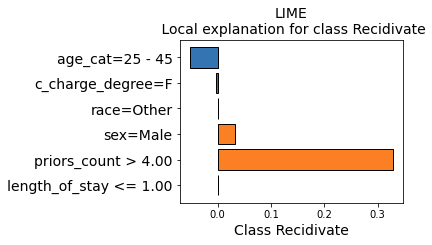

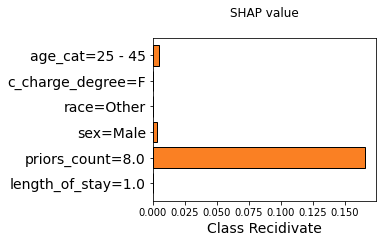

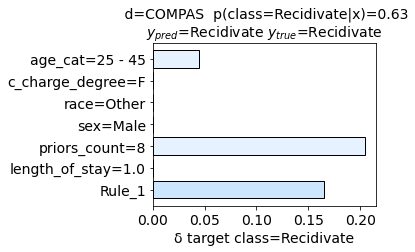

In [31]:
for id_i in [7]:
    path, true_rule,target=getPathDecisionTree(pc.clf, pc.OH_X_test_cols.iloc[id_i:id_i+1], pc, verbose=False)
    print("####################\ntarget")
    print(target)
    print(path)
    print(true_rule)
    from utils_RW import plot_lime_explanation
    predicted_class=pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1,-1))[0]
    print("LIME")
    exp_lime = lime_explainer.explain_instance(pc.test.iloc[id_i].values, pc.predict_fn, num_features=len(pc.feature_names), labels=[predicted_class])
    fig_lime = plot_lime_explanation(exp_lime, label=predicted_class, pred=pc.class_names[np.argmax(pc.predict_fn(pc.test.iloc[id_i:id_i+1].values))], true_label=pc.class_names[pc.labels_test[id_i]], fontsize=fontsize)
    if saveFig:
        saveFigure(fig_lime, outputDirResults, id_i, "lime")
    exp_lime_dict=lime_explanation_attr_sorted(exp_lime, predicted_class)
    lime_targets[id_i]=evaluateRankingTarget(exp_lime_dict,list(pc.feature_names), target)
    
    
    from utils_RW import sumCategories, plotShapValues, convertInstance
    print("SHAP")
    instance=pc.OH_X_test_cols.iloc[id_i]
    shap_values = shap_explainer.shap_values(instance)
    matching_instance=convertInstance(instance, pc.categorical_features, pc.continuos_features, pc.min_max_scaler)

    sum_shap_for_categories=sumCategories(shap_values[predicted_class], pc.oh_columns, pc.categorical_features, matching_instance)
    fig_shap=plotShapValues(list(sum_shap_for_categories.values()), list(sum_shap_for_categories.keys()), target_class=pc.class_names[predicted_class], \
                   pred=pc.class_names[pc.clf.predict([instance])[0]], true=pc.class_names[pc.labels_test[id_i]], fontsize=fontsize)
    if saveFig:
        saveFigure(fig_shap, outputDirResults, id_i, "shap")
    shap_targets[id_i]=evaluateRankingTarget(sum_shap_for_categories,list(pc.feature_names), target)

 
    from utils_RW import printAnchor, dictAnchor
    exp_anchor = anchor_explainer.explain_instance(pc.test.iloc[id_i].values, pc.predict_fn_class, threshold=0.95)
    printAnchor(id_i, exp_anchor)
    dictAnchor(id_i, exp_anchor)
    featureMasking=True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        pc.class_names[predicted_class],
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        verbose=False)
    fig_lace =explanation_fm.plotExplanation(showRuleKey=False, retFig=True, fontsize=fontsize)
    explanation_fm.local_rules.printLocalRules()
    if saveFig:
        saveFigure(fig_lace, outputDirResults, id_i, "lace")
    prediction_difference_attr=explanation_fm.getPredictionDifferenceDict()#{attrs_values[i]:explanation_fm.diff_single[i] for i in range(0,len(explanation_fm.diff_single))}
    lace_targets[id_i]=evaluateRankingTarget(prediction_difference_attr,list(pc.feature_names), target)


    
    changes=explanation_fm.estimateSingleAttributeChangePrediction()
#     if changes:
#         print(changes)

In [32]:
print([f"{k}={v}" for k,v in dict(explanation_fm.instance).items()])

['age_cat=25 - 45', 'c_charge_degree=F', 'race=Other', 'sex=Male', 'priors_count=8', 'length_of_stay=1.0', 'class=Recidivate']


# Evaluation

In [33]:
from quality_evaluation import *

In [34]:
showExplanation=True
saveFig=False
n_explanations=100

## Ranking

In [35]:
lime_targets={}
shap_targets={}
lace_targets={}
lime_targets_abs={}
shap_targets_abs={}
lace_targets_abs={}

In [36]:
lace_hits={"hit":0, "partial_hit_superset":0, "partial_hit_subset":0}
anchor_hits={"hit":0, "partial_hit_superset":0, "partial_hit_subset":0}
lace_rules_hit_all=[]
anchor_rules_hit_all=[]

In [37]:
fi_explainers = ["LIME", "SHAP", "LACE"]
feature_f1_score = {e: {} for e in fi_explainers}
feature_f1_score_delta = {e: {} for e in fi_explainers}
rule_explainers = ["anchor", "LACE"]
rule_f1_score = {e: {} for e in rule_explainers}

In [38]:
showExplanation=False

In [39]:
for id_i in range(0, n_explanations):
    path, true_rule, target = getPathDecisionTree(
        pc.clf, pc.OH_X_test_cols.iloc[id_i : id_i + 1], pc, verbose=False
    )

    true_rule_oh = [1 if f in target else 0 for f in list(pc.feature_names)]

    end_v = "\n" if id_i % 9 == 0 else " "
    print(f"{id_i} ({len(target)})", end=end_v)
    from utils_RW import plot_lime_explanation

    predicted_class = pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1, -1))[
        0
    ]

    exp_lime = lime_explainer.explain_instance(
        pc.test.iloc[id_i].values,
        pc.predict_fn,
        num_features=len(pc.feature_names),
        labels=[predicted_class],
    )

    if showExplanation:
        print("LIME")
        fig_lime = plot_lime_explanation(
            exp_lime,
            label=predicted_class,
            pred=pc.class_names[
                np.argmax(pc.predict_fn(pc.test.iloc[id_i : id_i + 1].values))
            ],
            true_label=pc.class_names[pc.labels_test[id_i]],
        )
        if saveFig:
            saveFigure(fig_lime, outdir_lime, id_i, "lime")
    exp_lime_dict = lime_explanation_attr_sorted(exp_lime, predicted_class)
    lime_targets[id_i] = evaluateRankingTarget(
        exp_lime_dict, list(pc.feature_names), target
    )
    lime_targets_abs[id_i] = evaluateRankingTarget(
        exp_lime_dict, list(pc.feature_names), target, absValue=True
    )

    expl_lime_fi = np.asarray((list(exp_lime_dict.values())))

    feature_f1_score["LIME"][id_i] = rule_based_similarity(
        np.asarray(true_rule_oh),
        np.asarray(feature_hit_oh_encoding(exp_lime_dict.values())),
    )
    feature_f1_score_delta["LIME"][id_i] = rule_based_similarity(
        np.asarray(true_rule_oh),
        np.asarray(feature_hit_oh_encoding_delta(exp_lime_dict.values())),
    )

    from utils_RW import sumCategories, plotShapValues, convertInstance

    instance = pc.OH_X_test_cols.iloc[id_i]
    shap_values = shap_explainer.shap_values(instance)
    matching_instance = convertInstance(
        instance, pc.categorical_features, pc.continuos_features
    )

    sum_shap_for_categories = sumCategories(
        shap_values[predicted_class],
        pc.oh_columns,
        pc.categorical_features,
        matching_instance,
    )
    if showExplanation:
        print("SHAP")
        fig_shap = plotShapValues(
            list(sum_shap_for_categories.values()),
            list(sum_shap_for_categories.keys()),
            target_class=pc.class_names[predicted_class],
            pred=pc.class_names[pc.clf.predict([instance])[0]],
            true=pc.class_names[pc.labels_test[id_i]],
        )
        if saveFig:
            saveFigure(fig_shap, outdir_shap, id_i, "shap")
    shap_targets[id_i] = evaluateRankingTarget(
        sum_shap_for_categories, list(pc.feature_names), target
    )
    shap_targets_abs[id_i] = evaluateRankingTarget(
        sum_shap_for_categories, list(pc.feature_names), target, absValue=True
    )
    expl_shap_fi = np.asarray((list(sum_shap_for_categories.values())))

    feature_f1_score["SHAP"][id_i] = rule_based_similarity(
        np.asarray(true_rule_oh),
        np.asarray(feature_hit_oh_encoding(sum_shap_for_categories.values())),
    )
    feature_f1_score_delta["SHAP"][id_i] = rule_based_similarity(
        np.asarray(true_rule_oh),
        np.asarray(feature_hit_oh_encoding_delta(sum_shap_for_categories.values())),
    )

    from utils_RW import printAnchor, dictAnchor

    exp_anchor = anchor_explainer.explain_instance(
        pc.test.iloc[id_i].values, pc.predict_fn_class, threshold=0.95
    )

    if showExplanation:
        printAnchor(id_i, exp_anchor)
        dictAnchor(id_i, exp_anchor)
    attributes_anchor_rules = [[
        list(pc.feature_names)[attr] for attr in exp_anchor.features()
    ]]
    anchor_hits, anchor_rules_hit = computeHits(
        attributes_anchor_rules, target, anchor_hits, verbose=False
    )
    anchor_rules_hit_all.append(anchor_rules_hit)

    rules_anchor_oh = [
        oh_encoding_rule(rule, pc.feature_names) for rule in attributes_anchor_rules
    ]
    if rules_anchor_oh ==[]:
        rules_anchor_oh = [oh_encoding_rule([], pc.feature_names)]

    rule_f1_score["anchor"][id_i] = max(
        [
            rule_based_similarity(np.asarray(r), np.asarray(true_rule_oh))
            for r in rules_anchor_oh
        ]
    )

    featureMasking = True
    instance = pc.d_explain[id_i]
    infos = {"model": classifier_name}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        pc.class_names[predicted_class],
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        verbose=False,
    )
    if showExplanation:
        fig_lace = explanation_fm.plotExplanation(showRuleKey=False, retFig=True)
        # explanation_fm.local_rules.printLocalRules()
        if saveFig:
            saveFigure(fig_lace, outdir_lace, id_i, "lace")
        changes = explanation_fm.estimateSingleAttributeChangePrediction()
        #if changes:
        #    print(changes)
    prediction_difference_attr = (
        explanation_fm.getPredictionDifferenceDict()
    )  # {attrs_values[i]:explanation_fm.diff_single[i] for i in range(0,len(explanation_fm.diff_single))}
    lace_targets[id_i] = evaluateRankingTarget(
        prediction_difference_attr, list(pc.feature_names), target
    )
    lace_targets_abs[id_i] = evaluateRankingTarget(
        prediction_difference_attr, list(pc.feature_names), target, absValue=True
    )
    attributes_lace_rules = explanation_fm.getAttributesRules()
    lace_hits, lace_rules_hit = computeHits(
        attributes_lace_rules, target, lace_hits, verbose=False
    )
    lace_rules_hit_all.append(lace_rules_hit)

    expl_lace_fi = np.asarray((list(prediction_difference_attr.values())))

    feature_f1_score["LACE"][id_i] = rule_based_similarity(
        np.asarray(true_rule_oh),
        np.asarray(feature_hit_oh_encoding(prediction_difference_attr.values())),
    )
    feature_f1_score_delta["LACE"][id_i] = rule_based_similarity(
        np.asarray(true_rule_oh),
        np.asarray(
            feature_hit_oh_encoding_delta(prediction_difference_attr.values())
        ),
    )

    rules_lace_oh = [
        oh_encoding_rule(rule, pc.feature_names) for rule in attributes_lace_rules
    ]

    if rules_lace_oh == []:
        rules_lace_oh = [oh_encoding_rule([], pc.feature_names)]
    rule_f1_score["LACE"][id_i] = max(
        [
            rule_based_similarity(np.asarray(r), np.asarray(true_rule_oh))
            for r in rules_lace_oh
        ]
    )
print()


0 (1)
1 (2) 2 (2) 3 (3) 4 (3) 5 (2) 6 (2) 7 (2) 8 (2) 9 (2)
10 (3) 11 (1) 12 (3) 13 (2) 14 (3) 15 (2) 16 (2) 17 (2) 18 (3)
19 (2) 20 (2) 21 (2) 22 (3) 23 (2) 24 (1) 25 (2) 26 (3) 27 (2)
28 (2) 29 (2) 30 (3) 31 (3) 32 (2) 33 (2) 34 (2) 35 (2) 36 (2)
37 (2) 38 (3) 39 (2) 40 (2) 41 (2) 42 (2) 43 (3) 44 (2) 45 (1)
46 (1) 47 (2) 48 (1) 49 (2) 50 (2) 51 (2) 52 (2) 53 (1) 54 (1)
55 (3) 56 (2) 57 (2) 58 (2) 59 (3) 60 (3) 61 (3) 62 (2) 63 (2)
64 (2) 65 (2) 66 (2) 67 (3) 68 (2) 69 (2) 70 (2) 71 (2) 72 (2)
73 (2) 74 (2) 75 (2) 76 (3) 77 (2) 78 (2) 79 (2) 80 (1) 81 (2)
82 (2) 83 (3) 84 (1) 85 (2) 86 (3) 87 (2) 88 (2) 89 (2) 90 (2)
91 (2) 92 (2) 93 (2) 94 (2) 95 (2) 96 (2) 97 (2) 98 (2) 99 (2)



In [43]:
path, true_rule, target

(frozenset({'age_cat!=Less than 25', 'priors_count=0.0'}),
 frozenset({'age_cat=25 - 45', 'priors_count=0.0'}),
 frozenset({'age_cat', 'priors_count'}))

In [47]:
printResComplete=False

In [50]:
if printResComplete:
    print("feature_f1_score", feature_f1_score)

In [49]:
if printResComplete:
    print("lace_rules_hit_all", lace_rules_hit_all)
    print("anchor_rules_hit_all", anchor_rules_hit_all)

In [53]:
if printResComplete:
    print("feature_f1_score")
    print(feature_f1_score)

    print("feature_f1_score_delta")
    print(feature_f1_score_delta)

    print("rule_f1_score")
    print(rule_f1_score)

feature_f1_score_mean = computeAverage(feature_f1_score)
print("feature_f1_score_mean")
print(feature_f1_score_mean)

feature_f1_score_delta_mean = computeAverage(feature_f1_score_delta)
print("\nfeature_f1_score_delta_mean")
print(feature_f1_score_delta_mean)

rule_f1_score_mean = computeAverage(rule_f1_score)
print("\nrule_f1_score_mean")
print(rule_f1_score_mean)

feature_f1_score_mean
{'LIME': 0.5119047619047619, 'SHAP': 0.8099999999999998, 'LACE': 1.0}

feature_f1_score_delta_mean
{'LIME': 0.7403333333333333, 'SHAP': 0.8366666666666667, 'LACE': 1.0}

rule_f1_score_mean
{'anchor': 0.819857142857143, 'LACE': 0.8311428571428572}


### Ranking

In [55]:
if printResComplete:
    print("LIME")
    print(lime_targets)
    print("SHAP")
    print(shap_targets)
    print("LACE")
    print(lace_targets)

In [56]:
print("LIME", np.mean(list(lime_targets.values())))
print("SHAP", np.mean(list(shap_targets.values())))
print("LACE", np.mean(list(lace_targets.values())))

LIME 0.7683333333333334
SHAP 0.8983333333333334
LACE 0.8916666666666666


### Rule hits

In [57]:
print("LACE")
print(lace_hits)
print("Anchor")
print(anchor_hits)

LACE
{'hit': 57, 'partial_hit_superset': 8, 'partial_hit_subset': 28}
Anchor
{'hit': 42, 'partial_hit_superset': 26, 'partial_hit_subset': 32}


In [58]:
if saveResults:
    saveJson(lace_hits, "lace_hits", outputDirResults)
    saveJson(anchor_hits, "anchor_hits", outputDirResults)
    saveJson(lime_targets, "lime_targets", outputDirResults)
    saveJson(shap_targets, "shap_targets", outputDirResults)
    saveJson(lace_hits, "lace_targets", outputDirResults)


    mean_hit_targets={"LIME": np.mean(list(lime_targets.values())), 
    "SHAP":np.mean(list(shap_targets.values())),
    "LACE":np.mean(list(lace_targets.values()))}

    saveJson(mean_hit_targets, "mean_hit_targets", outputDirResults)

### Ranking abs

In [60]:
if printResComplete:
    print("LIME abs")
    print(lime_targets_abs)
    print("SHAP abs")
    print(shap_targets_abs)
    print("LACE abs")
    print(lace_targets_abs)

In [61]:
print("LIME abs", np.mean(list(lime_targets_abs.values())))
print("SHAP abs", np.mean(list(shap_targets_abs.values())))
print("LACE abs", np.mean(list(lace_targets_abs.values())))

LIME abs 1.0
SHAP abs 0.98
LACE abs 1.0


In [62]:
if saveResults:
    saveJson(lime_targets_abs, "lime_targets_abs", outputDirResults)
    saveJson(shap_targets_abs, "shap_targets_abs", outputDirResults)
    saveJson(lace_targets_abs, "lace_targets_abs", outputDirResults)


    mean_hit_targets_abs={"LIME": np.mean(list(lime_targets_abs.values())), 
    "SHAP":np.mean(list(shap_targets_abs.values())),
    "LACE":np.mean(list(lace_targets_abs.values()))}

    saveJson(mean_hit_targets_abs, "mean_hit_targets_abs", outputDirResults)

## Rule hit

In [63]:
from utils_RW import showHits

In [64]:
print(anchor_hits)
print(lace_hits)
hits_dict_summary={}
hits_dict_summary["LACE"]=lace_hits
hits_dict_summary["anchor"]=anchor_hits

{'hit': 42, 'partial_hit_superset': 26, 'partial_hit_subset': 32}
{'hit': 57, 'partial_hit_superset': 8, 'partial_hit_subset': 28}


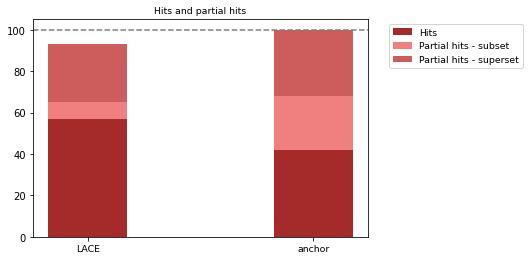

In [65]:
showHits(hits_dict_summary, upperLabel=n_explanations, percentage=True, saveFig=saveResults, outDir=outputDirResults)